In [1]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
X_train = X_train[y_train.squeeze()==1] #retaining class 1 images in cifar10 dataset

In [4]:
#z score normaization
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std


In [5]:
# define variables
IMG_SIZE = 32 # input size for CIFAR = 32x32
BATCH_SIZE = 128 # batch size for training
timesteps = 16 #steps for a noisy image to clear
time_bar = 1 - np.linspace(0,1.0,timesteps+1) #linespace for timesteps

In [6]:
def cnvrtImg(img):
  img = img - img.min() #subtracting min pixel value from every pixel in image (shifts pixel values to start from 0 making min pixel value 0)
  img = (img / img.max()) #normalizing image by dividing pixels by the max pixel value (scales pixel values to 0,1 range)
  return img.astype(np.float32) # converts image into numpy array of datatype float32 and returns it

In [7]:
def shw_eg(x):
  plt.figure(figsize=(10,10)) # creates a matplotlib figure with 10x10 inches size
  # function  below sets up a loop that iterates through first 25 images in x array
  for i in range(25):
    plt.subplot(5,5,i+1) #subplot within figure arranging them in 5x5 grid with i+1 = index
    img=cnvrtImg(x[i]) # calls the previous function to current image within loop, normalizing it and storing in img
    plt.imshow(img) # displays normalized image
    plt.axis('off') #turns of axis labels

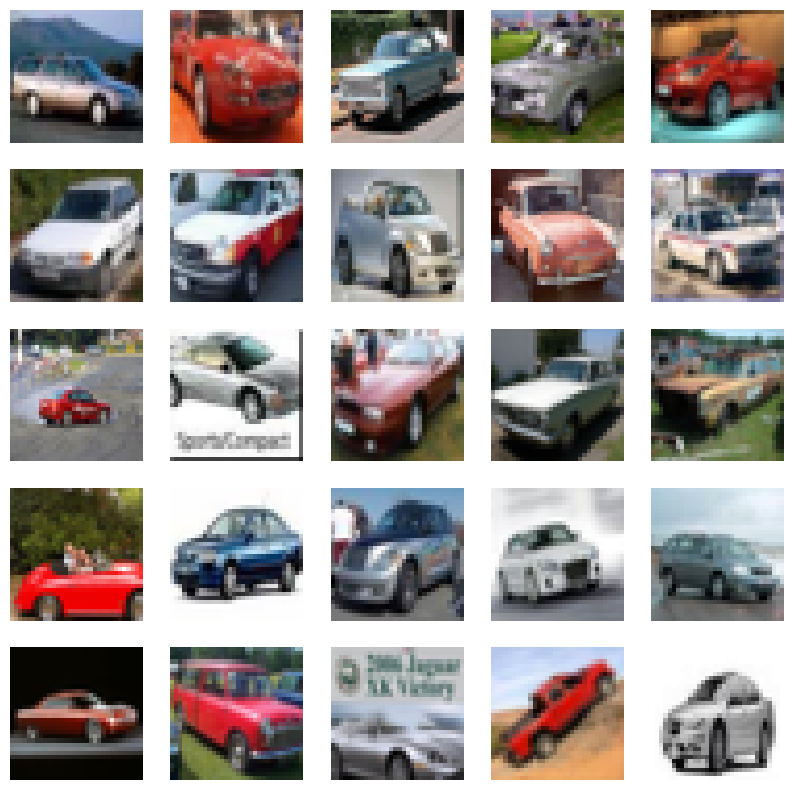

In [8]:
shw_eg(X_train)

In [9]:
def forward_noise(x, t):
  a = time_bar[t] # extracting values from time_bar at time steps t and t+1
  b = time_bar[t + 1] # image for t+1

  noise = np.random.normal(size=x.shape) # generates random noise with same shape as input image (noise mask)
  a = a.reshape((-1,1,1,1)) #reshaping a and b variables to 4D arrays(-1 is used to preserve total elements in array while changing dimensions)
  b = b.reshape((-1,1,1,1))
  img_a = x * (1-a) + noise * a # apply a linear combination of x and noise based on vals of a and b. Purpose is to blend original image x with noise according to values of a and b
  img_b = x * (1-b) + noise * b # similar combination except it is based on values of b and noise
  return img_a, img_b

In [10]:
def gen_ts(num):
  return np.random.randint(0, timesteps, size=num)

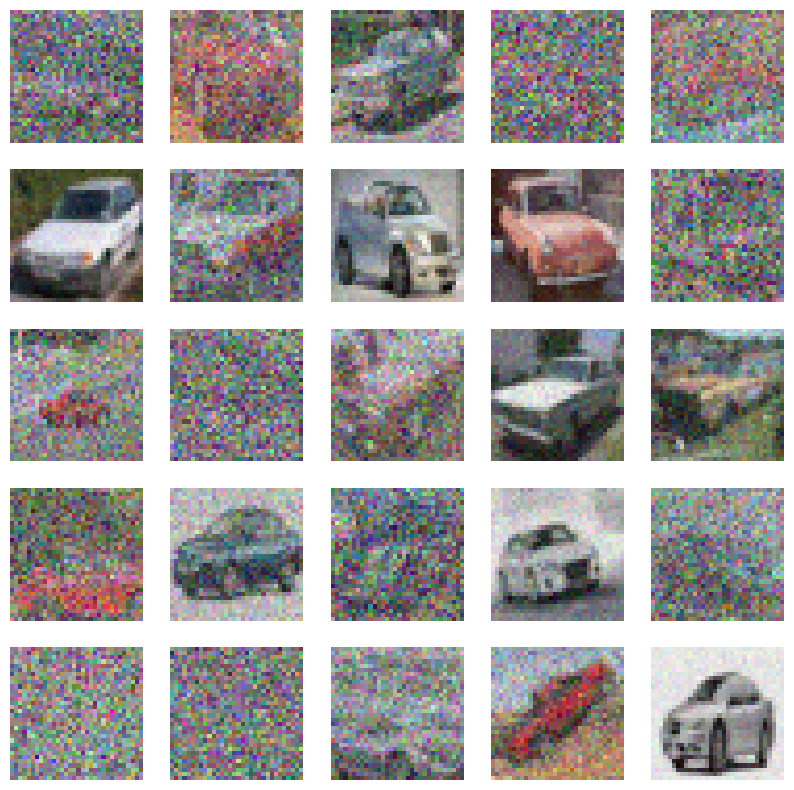

In [11]:
# t= np.full((25,), timesteps-1) for clarity
# t=np.full((25,), 0) for noisey

t = gen_ts(25) # random for training data
a, b = forward_noise(X_train[:25], t)
shw_eg(a)

In [12]:
def block(x_img, x_ts):
  x_param = layers.Conv2D(128, kernel_size=3, padding='same')(x_img) # applies a 2D convolutional layer with 128 filters and kernel size of 3x3  and 'same' padding to the input (x_img)
  x_param = layers.Activation('relu')(x_param) # applies relu activation to the feature maps obtained from cnn layer

  time_param = layers.Dense(128)(x_ts) # applies fully connected Dense layer with 128 units to the input (x_ts)
  time_param = layers.Activation('relu')(time_param) # similar to the convolutional layer relu is applied here as well to the params from the dense layer
  time_param = layers.Reshape((1, 1, 128))(time_param) # reshapes the output of the dense layer to have only 1 dimension (1,1,128)
  x_param = x_param * time_param

  X_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img) #applies another convolutional layer with the 128 filters to the original input image
  X_out = X_out + x_param # the output of the convolutional layer is added to the modulated x_param (from earlier operations)
  X_out = layers.LayerNormalization()(X_out) # layer normalization is applied to normalize feature of X_out
  X_out = layers.Activation('relu')(X_out) #another relu activation applied


  return X_out

In [13]:
# define a function to create the model
def make_model():
    # define the input for image data (3-channel images)
    x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    # define the input for time-related data (a single value)
    x_ts_input = layers.Input(shape=(1,), name='x_ts_input')

    # process time related input
    x_ts = layers.Dense(192)(x_ts_input)  # apply dense layer with 192 units
    x_ts = layers.LayerNormalization()(x_ts)  # normalize time-related data
    x_ts = layers.Activation('relu')(x_ts)  # apply relu activation

    # define left(downward) part of the model
    x = x32 = block(x_input, x_ts)  # apply "block" function
    x = layers.MaxPool2D(2)(x)  # downsample with max pooling
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    x = x8 = block(x,x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x,x_ts)

    #flatten and concatenate the feature maps and time-related data for MLP
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    # expanding flattened data to 4x4x32 feature map
    x = layers.Dense(4*4*32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4,4,32))(x)

    # defining the right (upward) part of the model including concatenation and 'block' application
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)  # Upsample using 2x2 upsampling

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # define final output layer with 3 channels
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)

    # initialize model with inputs and outputs
    model = tf.keras.models.Model([x_input, x_ts_input], x)

    # return model
    return model

# make the model using make_model function
model = make_model()

In [14]:
# compile the model
optim = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optim)

  0%|          | 0/16 [00:00<?, ?it/s]

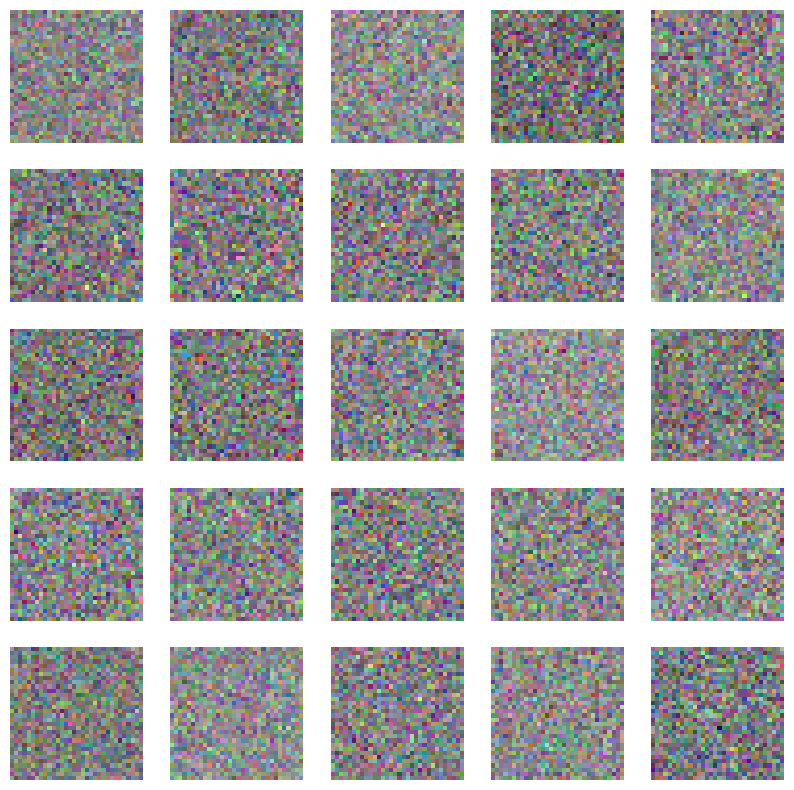

In [15]:
# predicting the results
# (non trained model output)
def predict(x_idx=None):
  x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3)) # generate random noise data as the initial input

  #loop through 'timesteps' no of timesteps
  for i in trange(timesteps):
    t = 1 # setting current timestep
    x - model.predict([x, np.full((32), t)], verbose=0) #using the model to predict the next state based on current state (x) and time input (t) set to the current timestep
  # show examples of final generated data
  shw_eg(x)
# call predict function to generate predictions
predict()

In [16]:
# training the model
def train_model(x_img):
  x_ts = gen_ts(len(x_img))
  x_a, x_b = forward_noise(x_img, x_ts)
  loss = model.train_on_batch([x_a, x_ts], x_b)
  return loss

In [17]:
# need to provide x_ts and x_img to enable our model to learn how to generate x_b (denoised image)
def train(R=50):
  bar = trange(R)
  total = 100
  for i in bar:
    for j in range(total):
      x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
      loss = train_model(x_img)
      pg = (j/total)*100
      if j % 5 == 0:
        bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/16 [00:00<?, ?it/s]

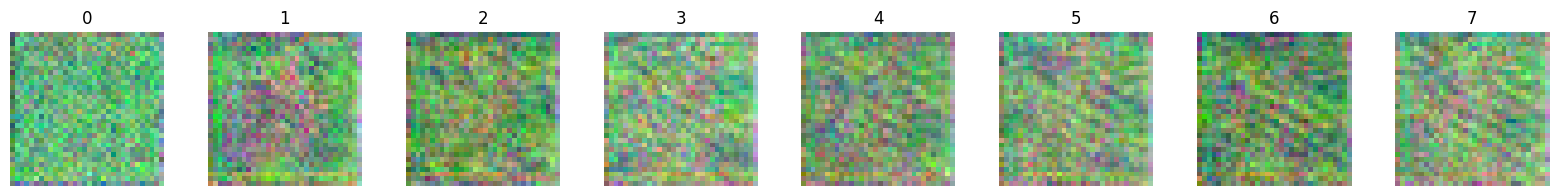

In [18]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cnvrtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

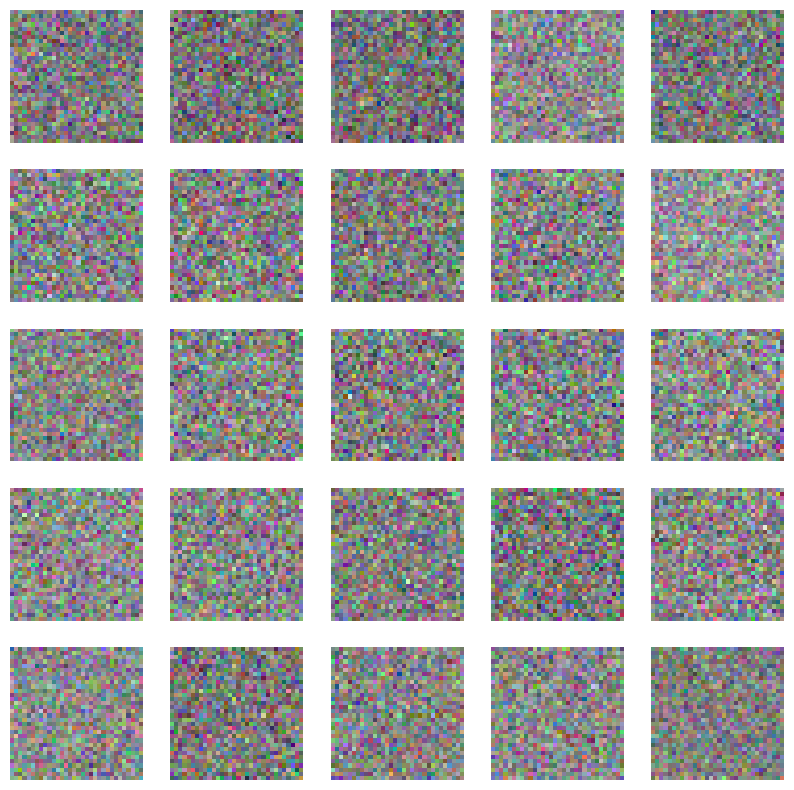

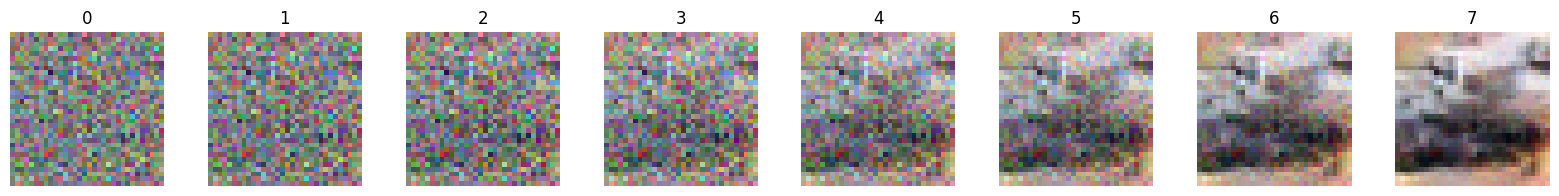

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

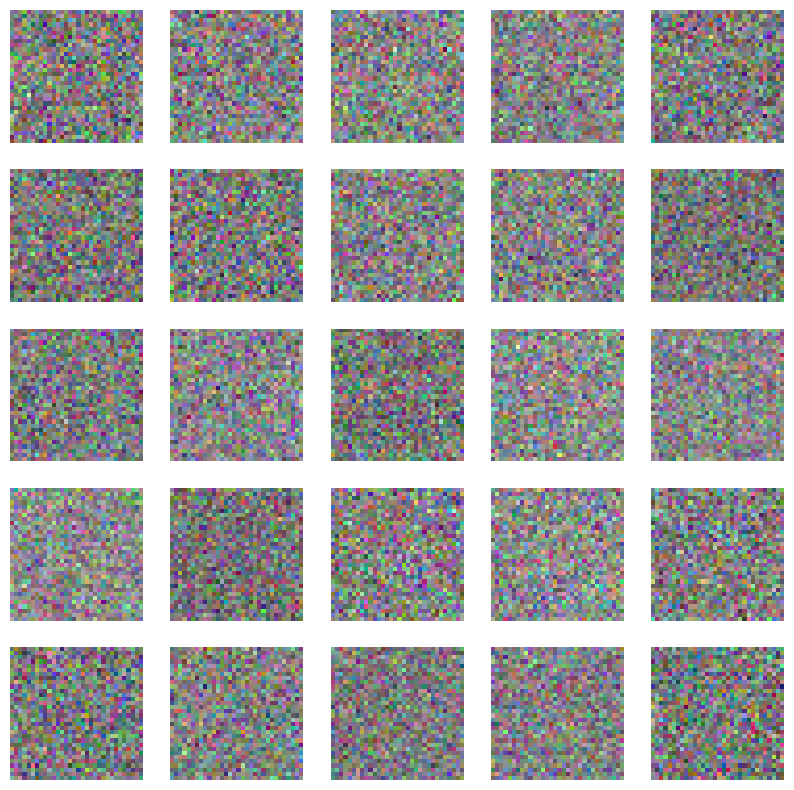

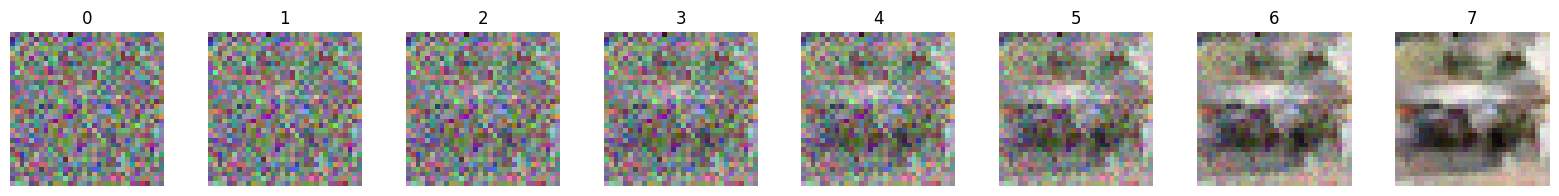

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

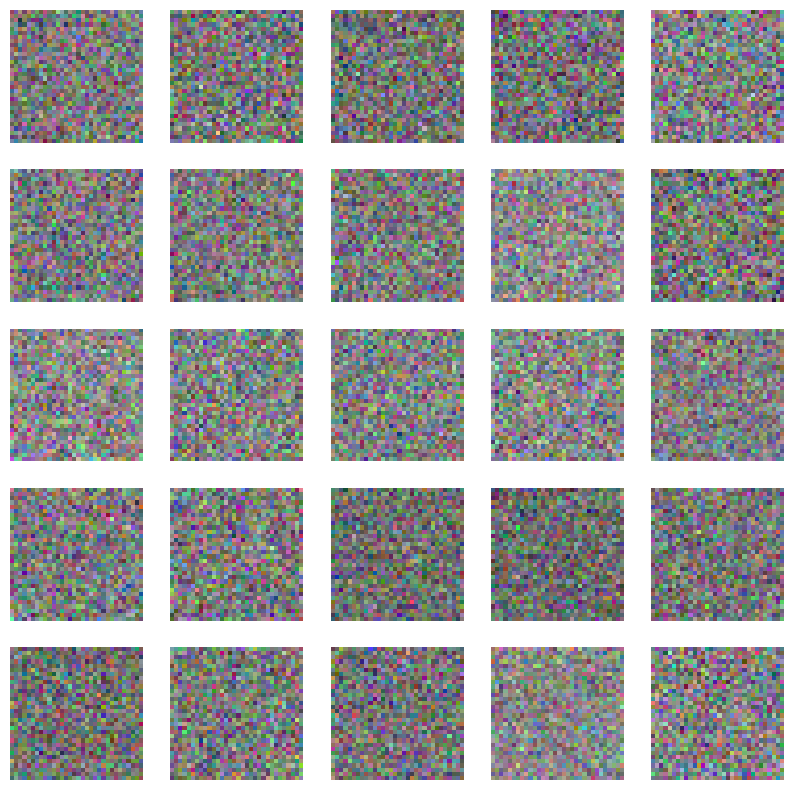

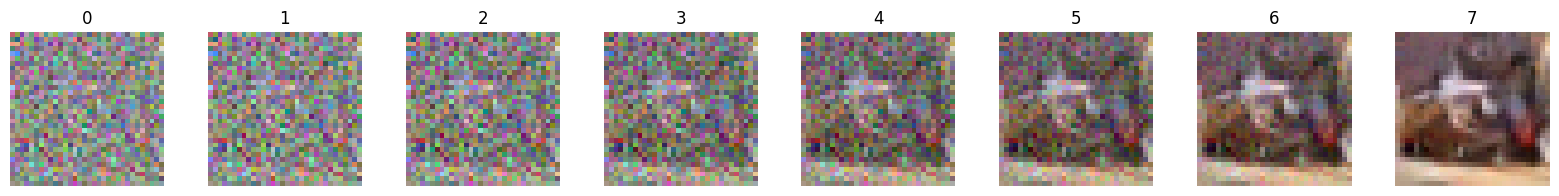

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

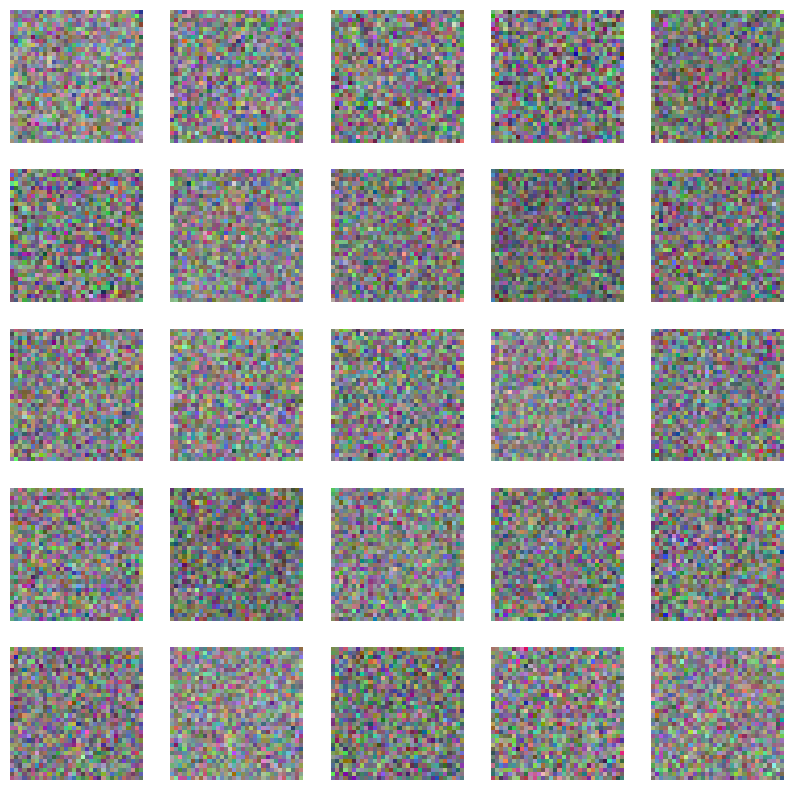

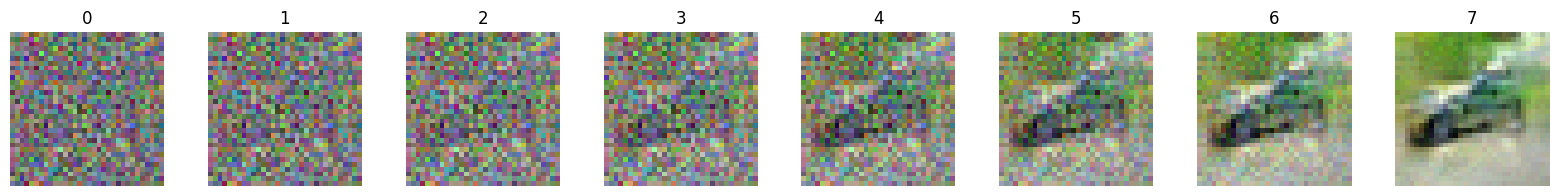

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

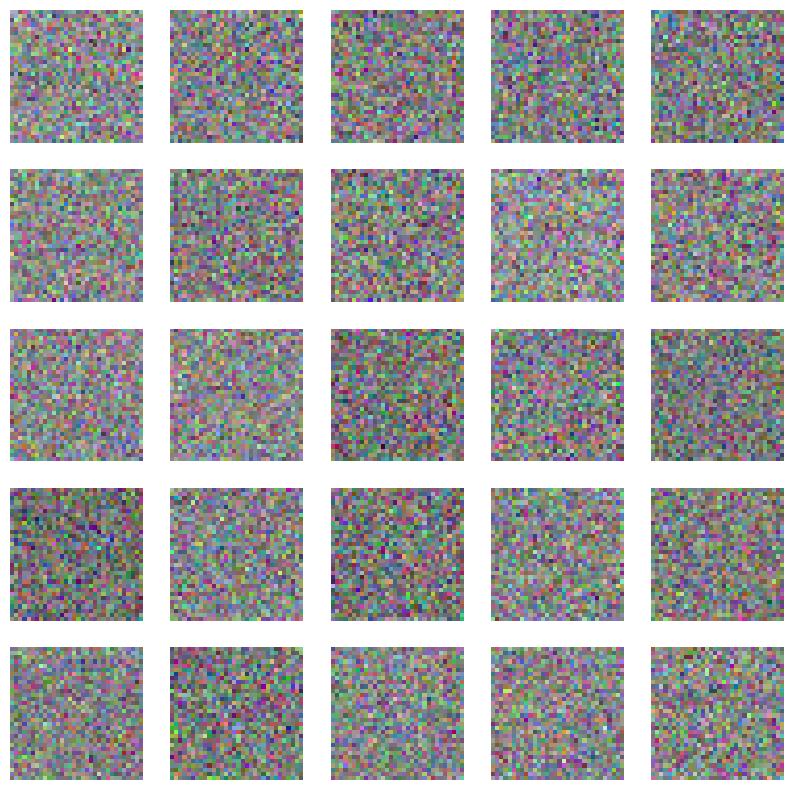

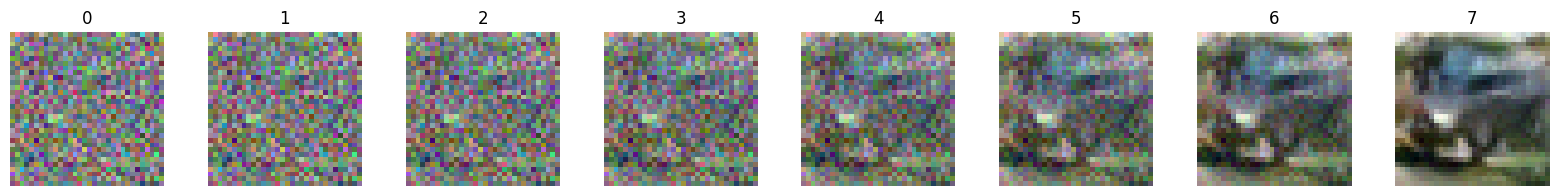

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

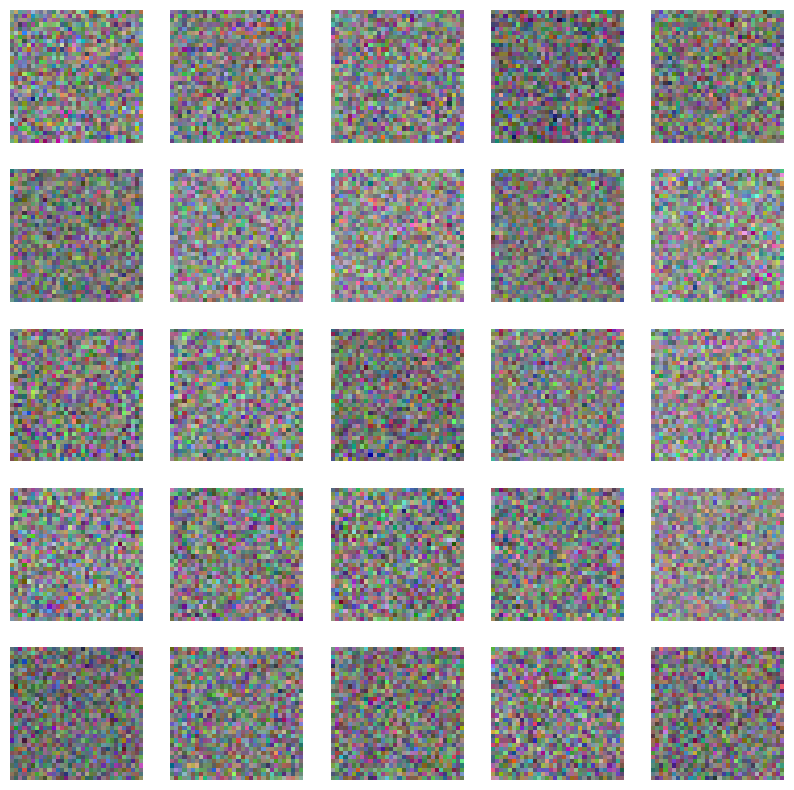

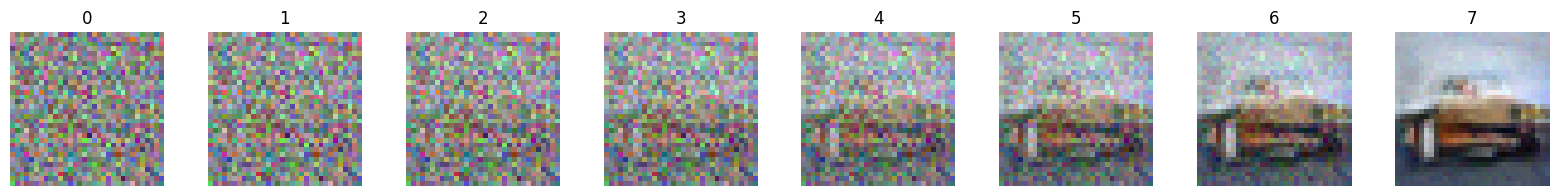

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

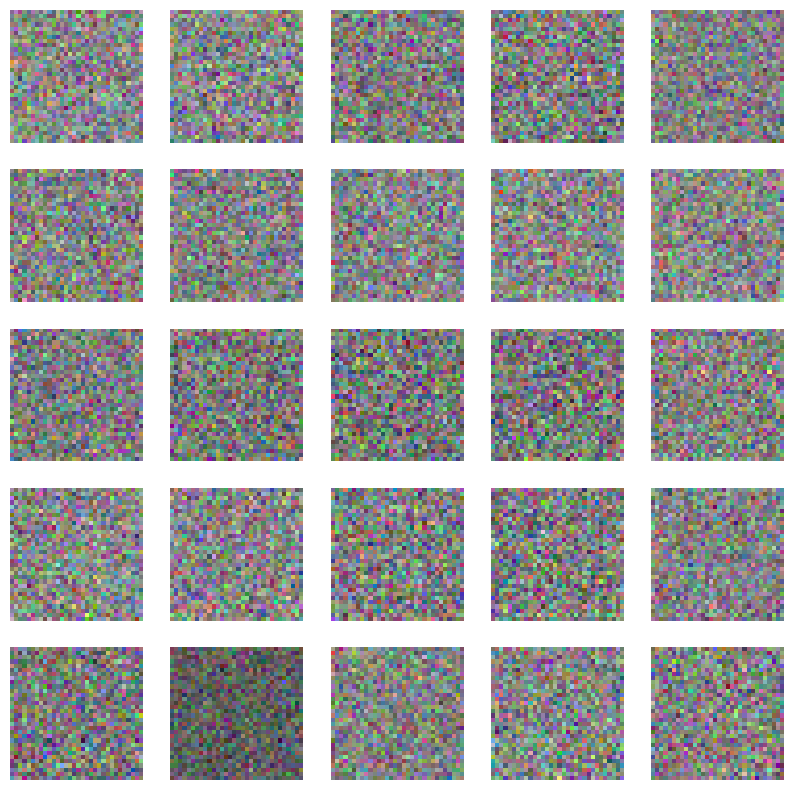

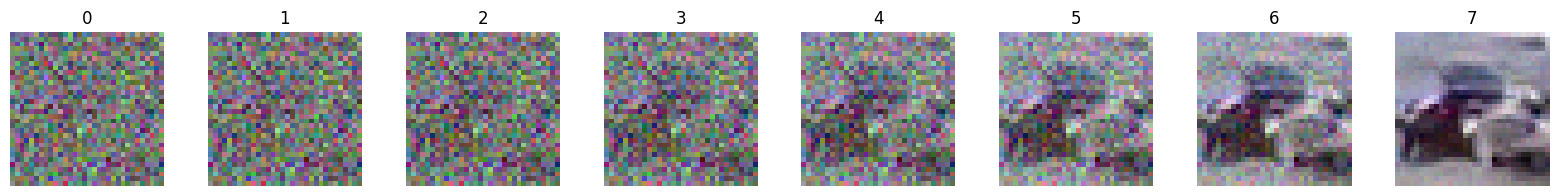

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

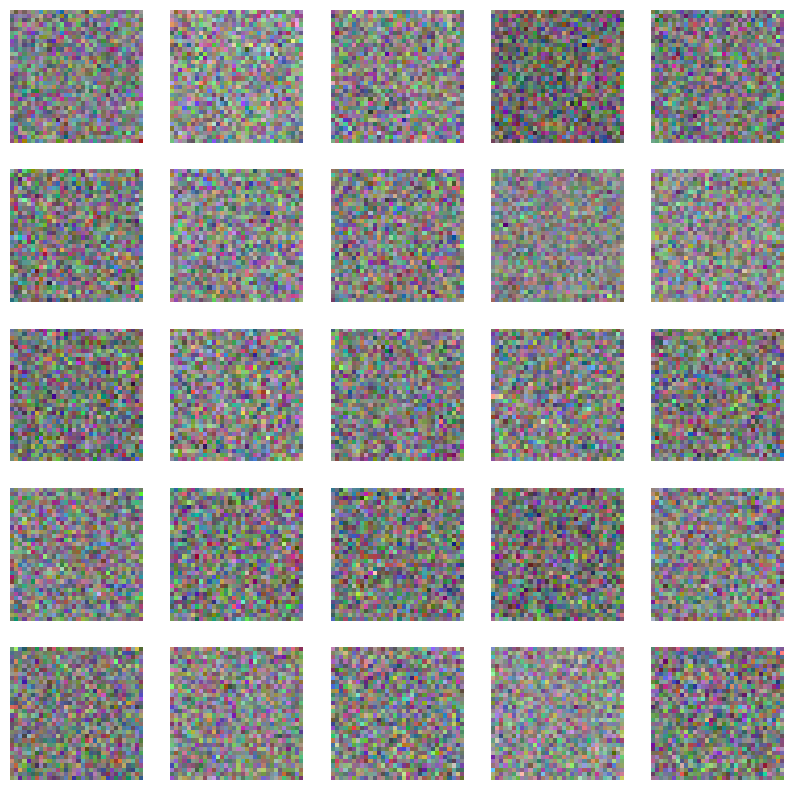

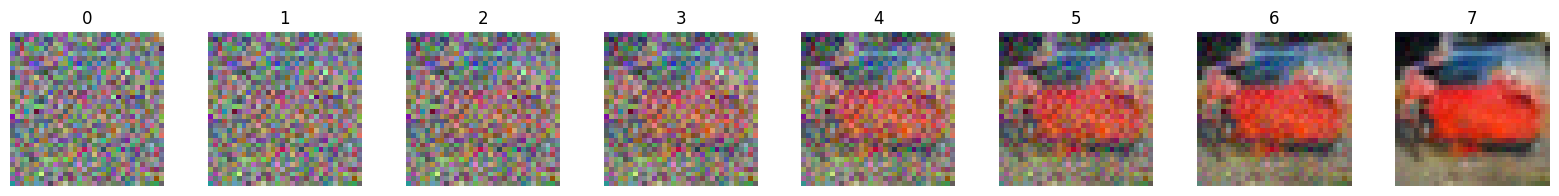

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

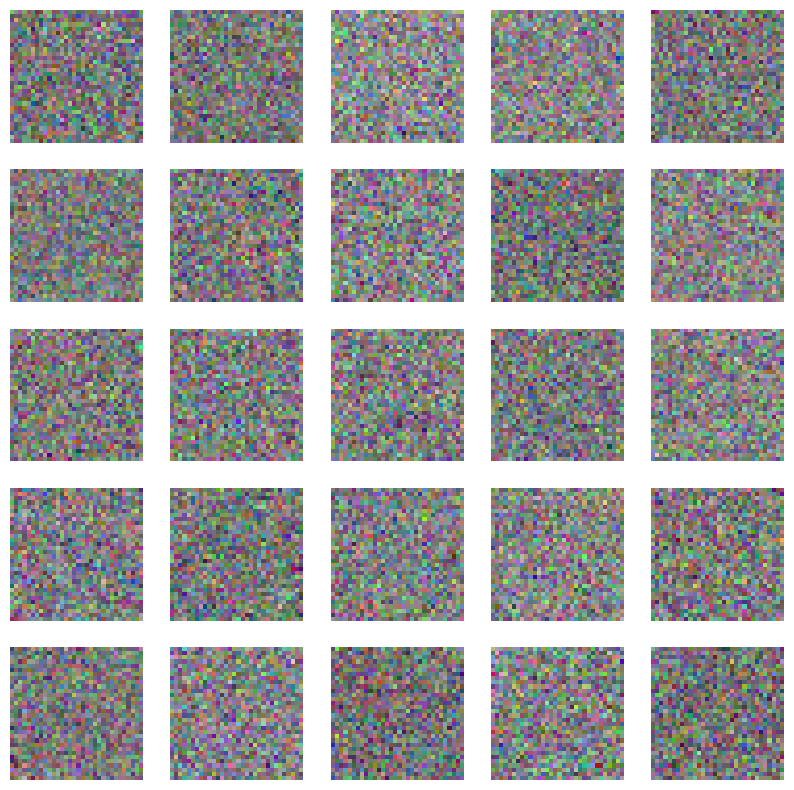

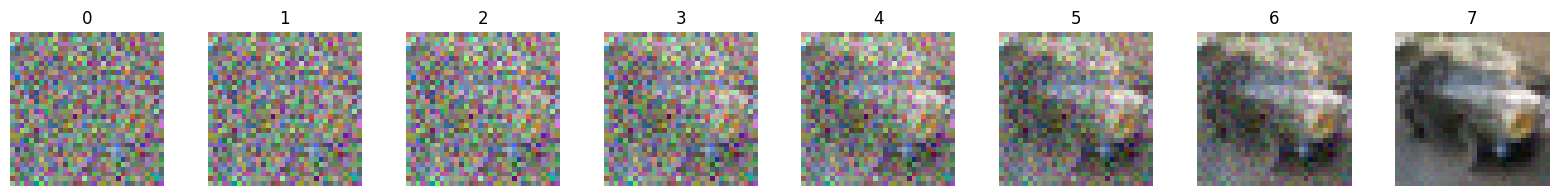

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

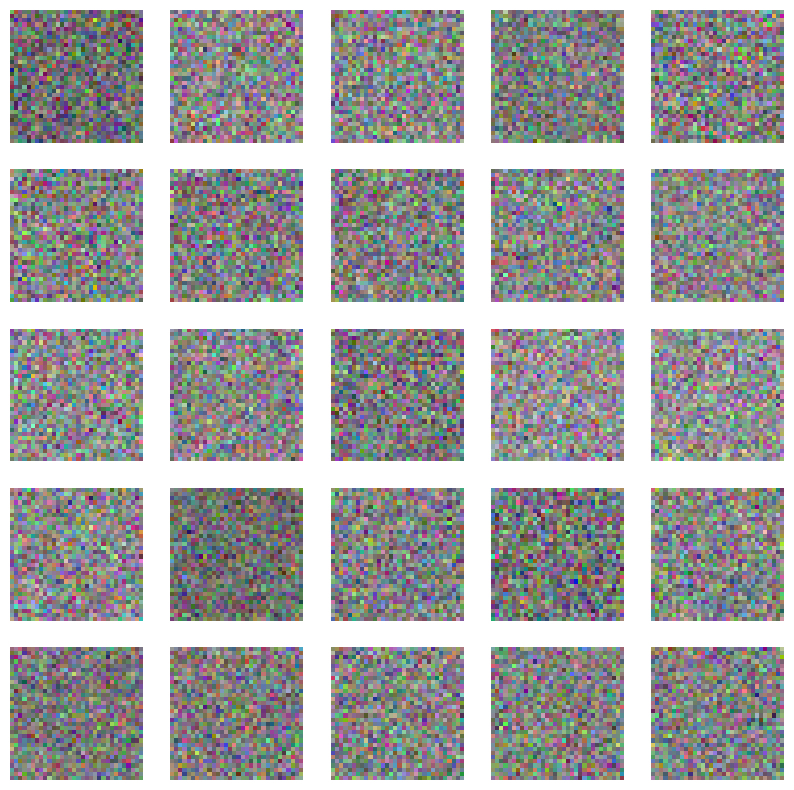

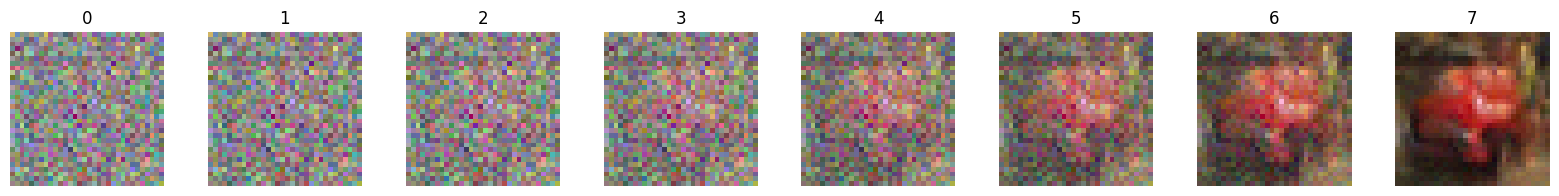

In [19]:
# reduce learning rate through multiple runs
for _ in range(10):
  train()
  # reduce the learning rate for the next training
  model.optimizer.learning_rate=max(0.000001, model.optimizer.learning_rate*0.9)
  # display result
  predict()
  predict_step()
  plt.show()